# EndotyPy package usage

In [1]:
import EndotypY as edy #type: ignore
import pickle
import networkx as nx

# manual test case seed clustering

In [2]:
# 1. Create an empty graph
G_test = nx.Graph()

# 2. Define seeds and the central hub node
seeds = ["S1", "S2", "S3", "S4"]
hub_node = "HUB"
spoke_len = 39 # This ensures the hub is the 40th node added

# 3. Build the spokes and connect them to the hub
for i, seed in enumerate(seeds):
    # The first node in the spoke is the seed itself
    previous_node = seed
    G_test.add_node(seed)
    
    # Create a chain of nodes for the spoke
    for j in range(spoke_len - 1):
        # Node names are unique to each spoke, e.g., "S1_node_1", "S2_node_1"
        new_node = f"{seed}_node_{j}"
        G_test.add_edge(previous_node, new_node)
        previous_node = new_node
        
    # Connect the end of the spoke to the central hub
    G_test.add_edge(previous_node, hub_node)

print(f"Test graph created with {G_test.number_of_nodes()} nodes and {G_test.number_of_edges()} edges.")
print(f"Seeds are: {seeds}")
print(f"Shortest path between S1 and S2 is {len(nx.shortest_path(G_test, 'S1', 'S2')) - 1} hops.")



Test graph created with 157 nodes and 156 edges.
Seeds are: ['S1', 'S2', 'S3', 'S4']
Shortest path between S1 and S2 is 78 hops.


In [3]:
test_case = edy.Endotyper()
test_case.network = G_test
test_case.seeds = seeds

test_case.prepare_rwr(r=0.8)

Preparing RWR...
Inverting the matrix takes time, please be patient...
RWR matrix prepared successfully


Running RWR for seed genes: 100%|██████████| 4/4 [00:00<00:00, 10645.44it/s]

Testing neighborhood sizes in parallel on 22 cores...



100%|██████████| 6/6 [00:00<00:00, 133152.51it/s]


Optimal neighborhood size found at k=10 with 4 cluster(s).


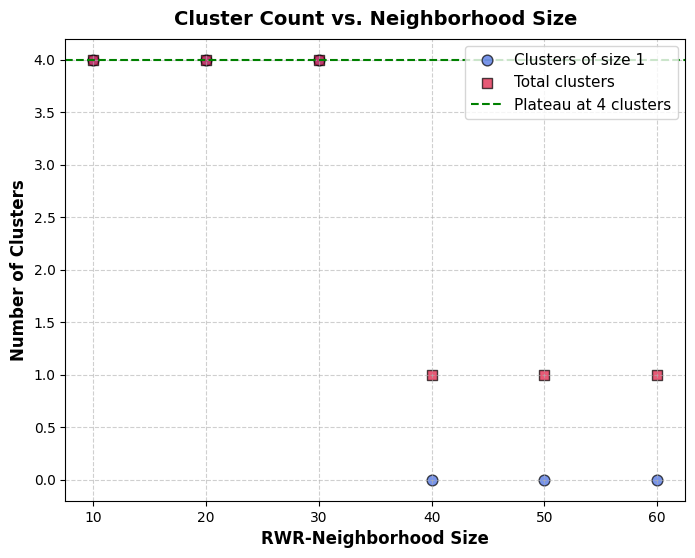

4 Seed clusters identified


{'cluster_seed_1': ['S1'],
 'cluster_seed_2': ['S2'],
 'cluster_seed_3': ['S3'],
 'cluster_seed_4': ['S4']}

In [4]:
test_case.explore_seed_clusters(scaling=True, k=60)

# endotypy analsysis

In [5]:
endo = edy.Endotyper()

# read in a graph from a file
path_ppi = 'monocyte.tsv'
#path_ppi = 'ppi.txt'
endo.import_network(path_ppi)

#path_seed = 'ibd_risk_genes_F.txt'
path_seed = 'ibd_risk_genes_mini.txt'
#read in a seed set from a file
#path_seed = 'example_seeds.txt'
endo.import_seeds(path_seed)

endo

network imported successfully
> Network contains 2866 nodes and 18725 edges

> Loaded 10 seed nodes from file: ibd_risk_genes_mini.txt
seeds imported successfully


In [6]:
#prepare RWR
endo.prepare_rwr(r=0.8)

Preparing RWR...
['HNF4A', 'PTPN22', 'IL2RA', 'S100A3', 'EBF1', 'FCN1', 'NKX2-3']
Inverting the matrix takes time, please be patient...
RWR matrix prepared successfully


Running RWR for seed genes: 100%|██████████| 3/3 [00:00<00:00, 86.09it/s]

Testing neighborhood sizes in parallel on 22 cores...



100%|██████████| 15/15 [00:00<00:00, 309923.94it/s]

Optimal neighborhood size found at k=40 with 1 cluster(s).


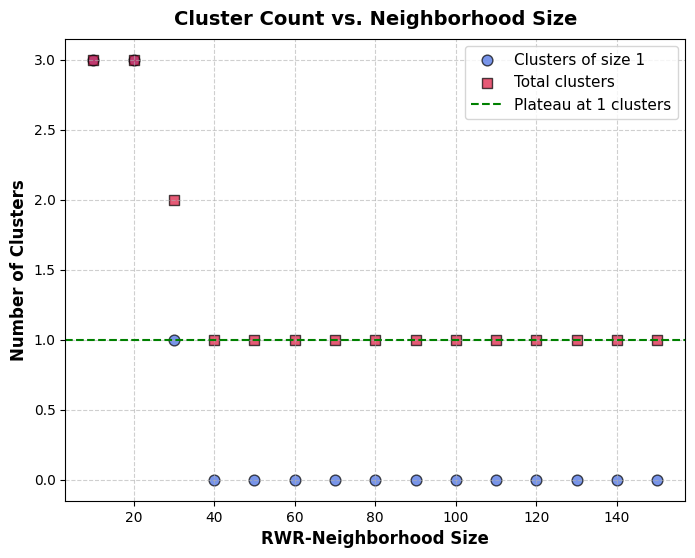

1 Seed clusters identified


{'cluster_seed_1': ['LRRK2', 'NOD2', 'CARD9']}

In [7]:
#explore the seed clusters
endo.explore_seed_clusters(scaling=True, k=150)

In [8]:
endo.extract_disease_module(seed_cluster_id = 1, scaling=True, k=40)

Using seed cluster ID 1 with 3 seeds
Connected module extracted with 43 nodes and 67 edges


In [9]:
endo.define_local_neighborhood(scaling=True, neighbor_percentage=1)

Running RWR for seed genes: 100%|██████████| 43/43 [00:00<00:00, 154.35it/s]


In [10]:
endo.annotate_local_neighborhood(enrichr_lib='Reactome_Pathways_2024',
                                 organism='Human',
                                 sig_threshold=0.05,
                                 force_download=False)

Loading Reactome_Pathways_2024 term library from cache...
Annotating local neighborhoods using Reactome_Pathways_2024 library...


### Old Endotype clustering

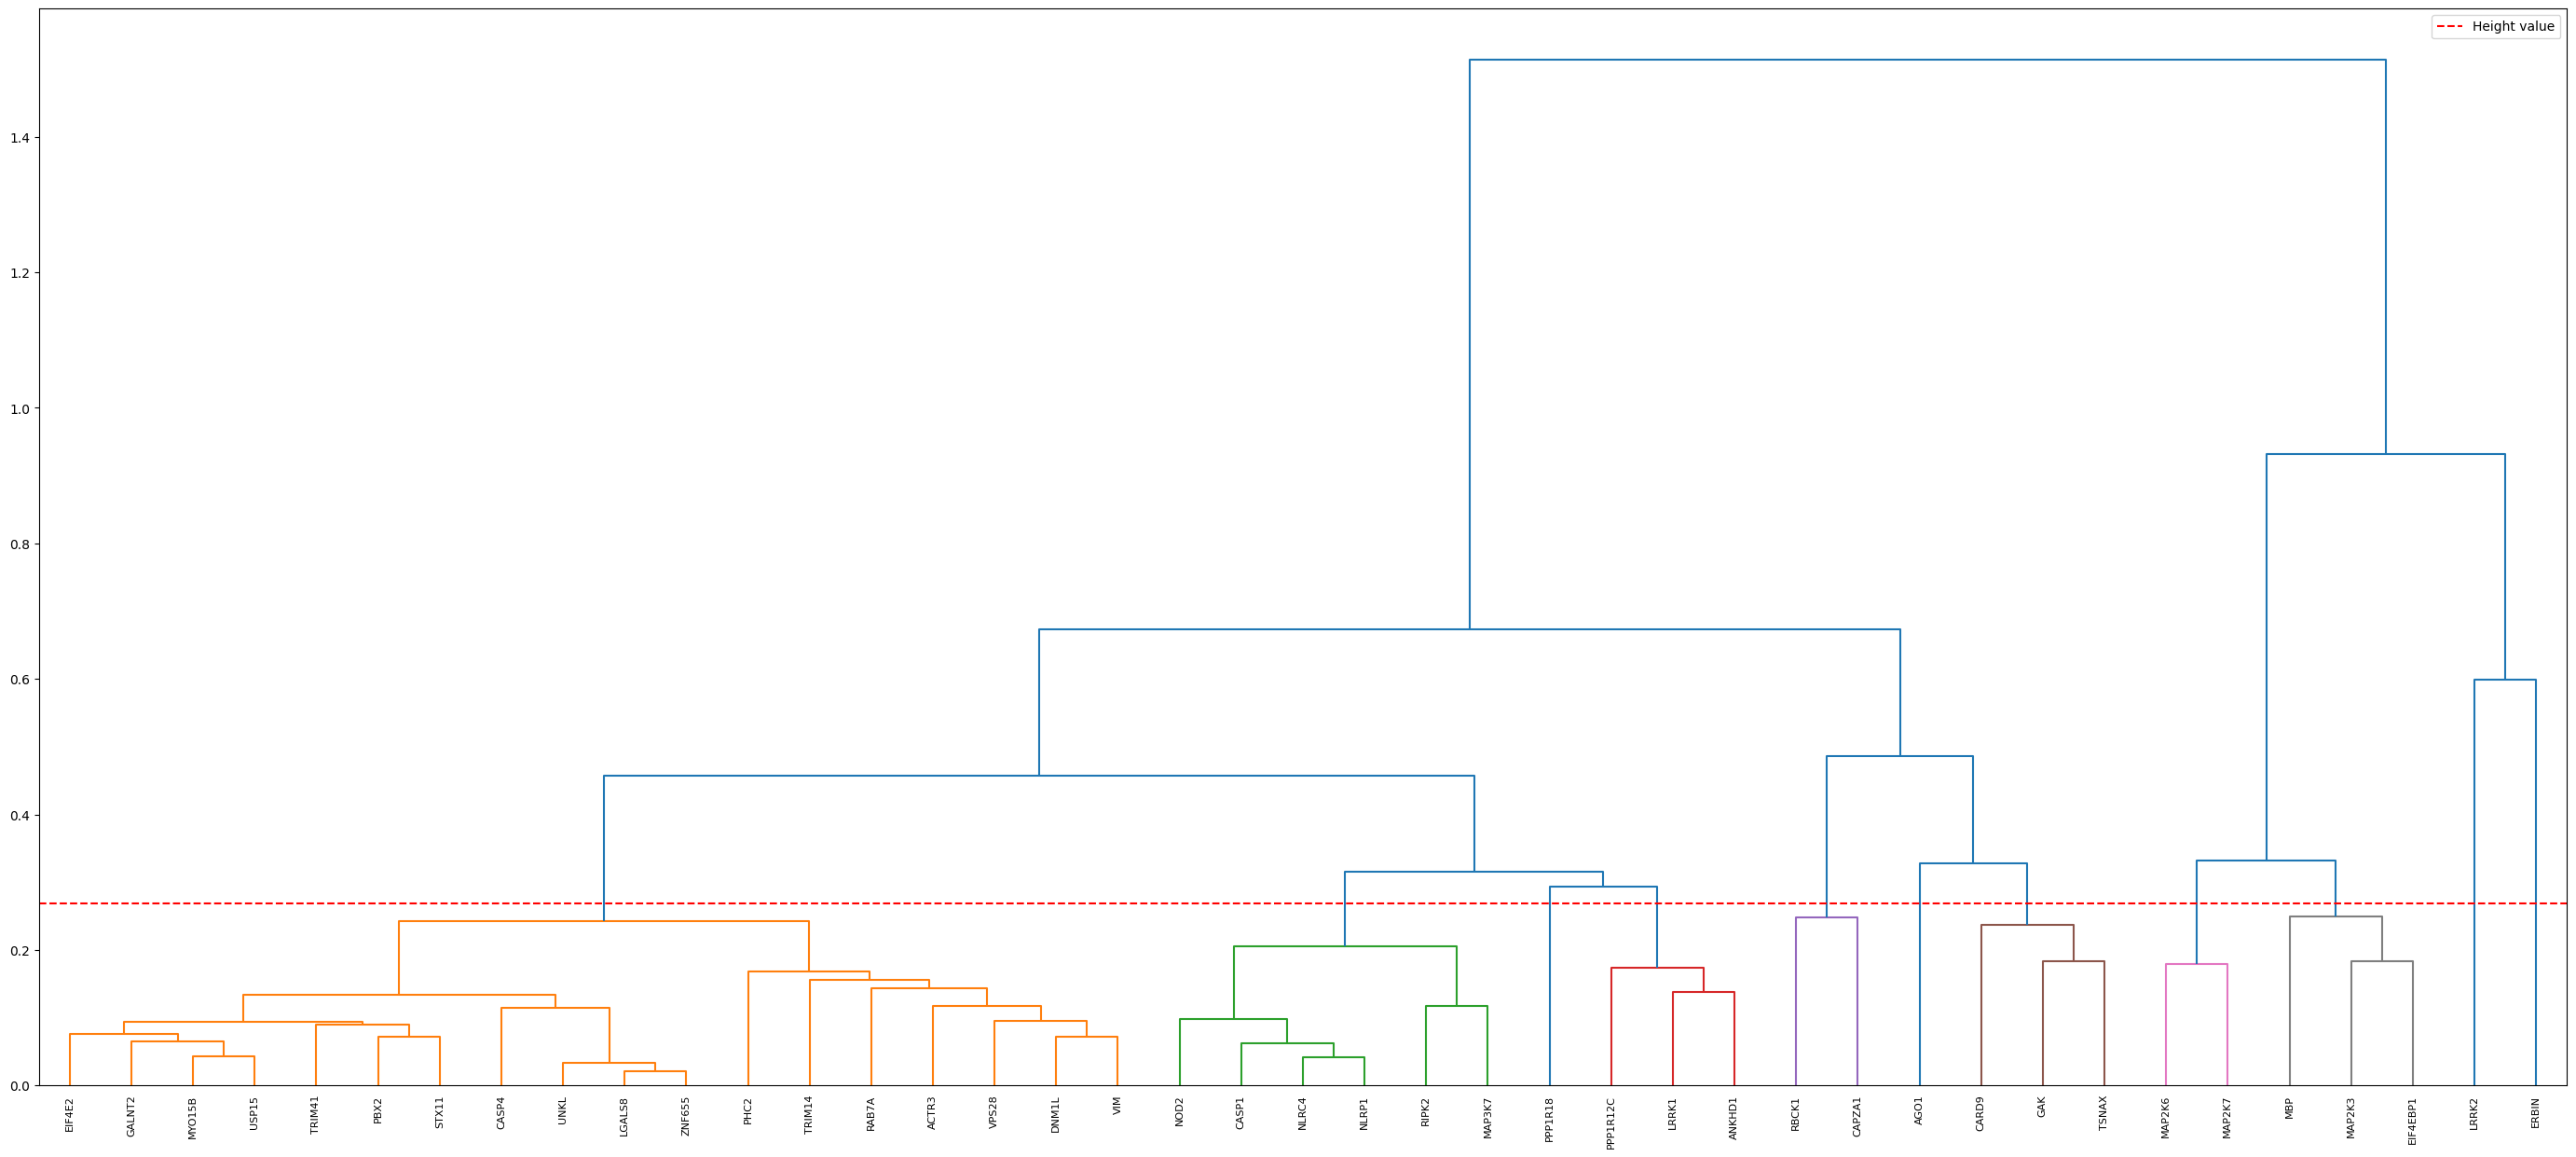

Iteration 1: 4 unassigned genes found.
Cluster numbers: 11


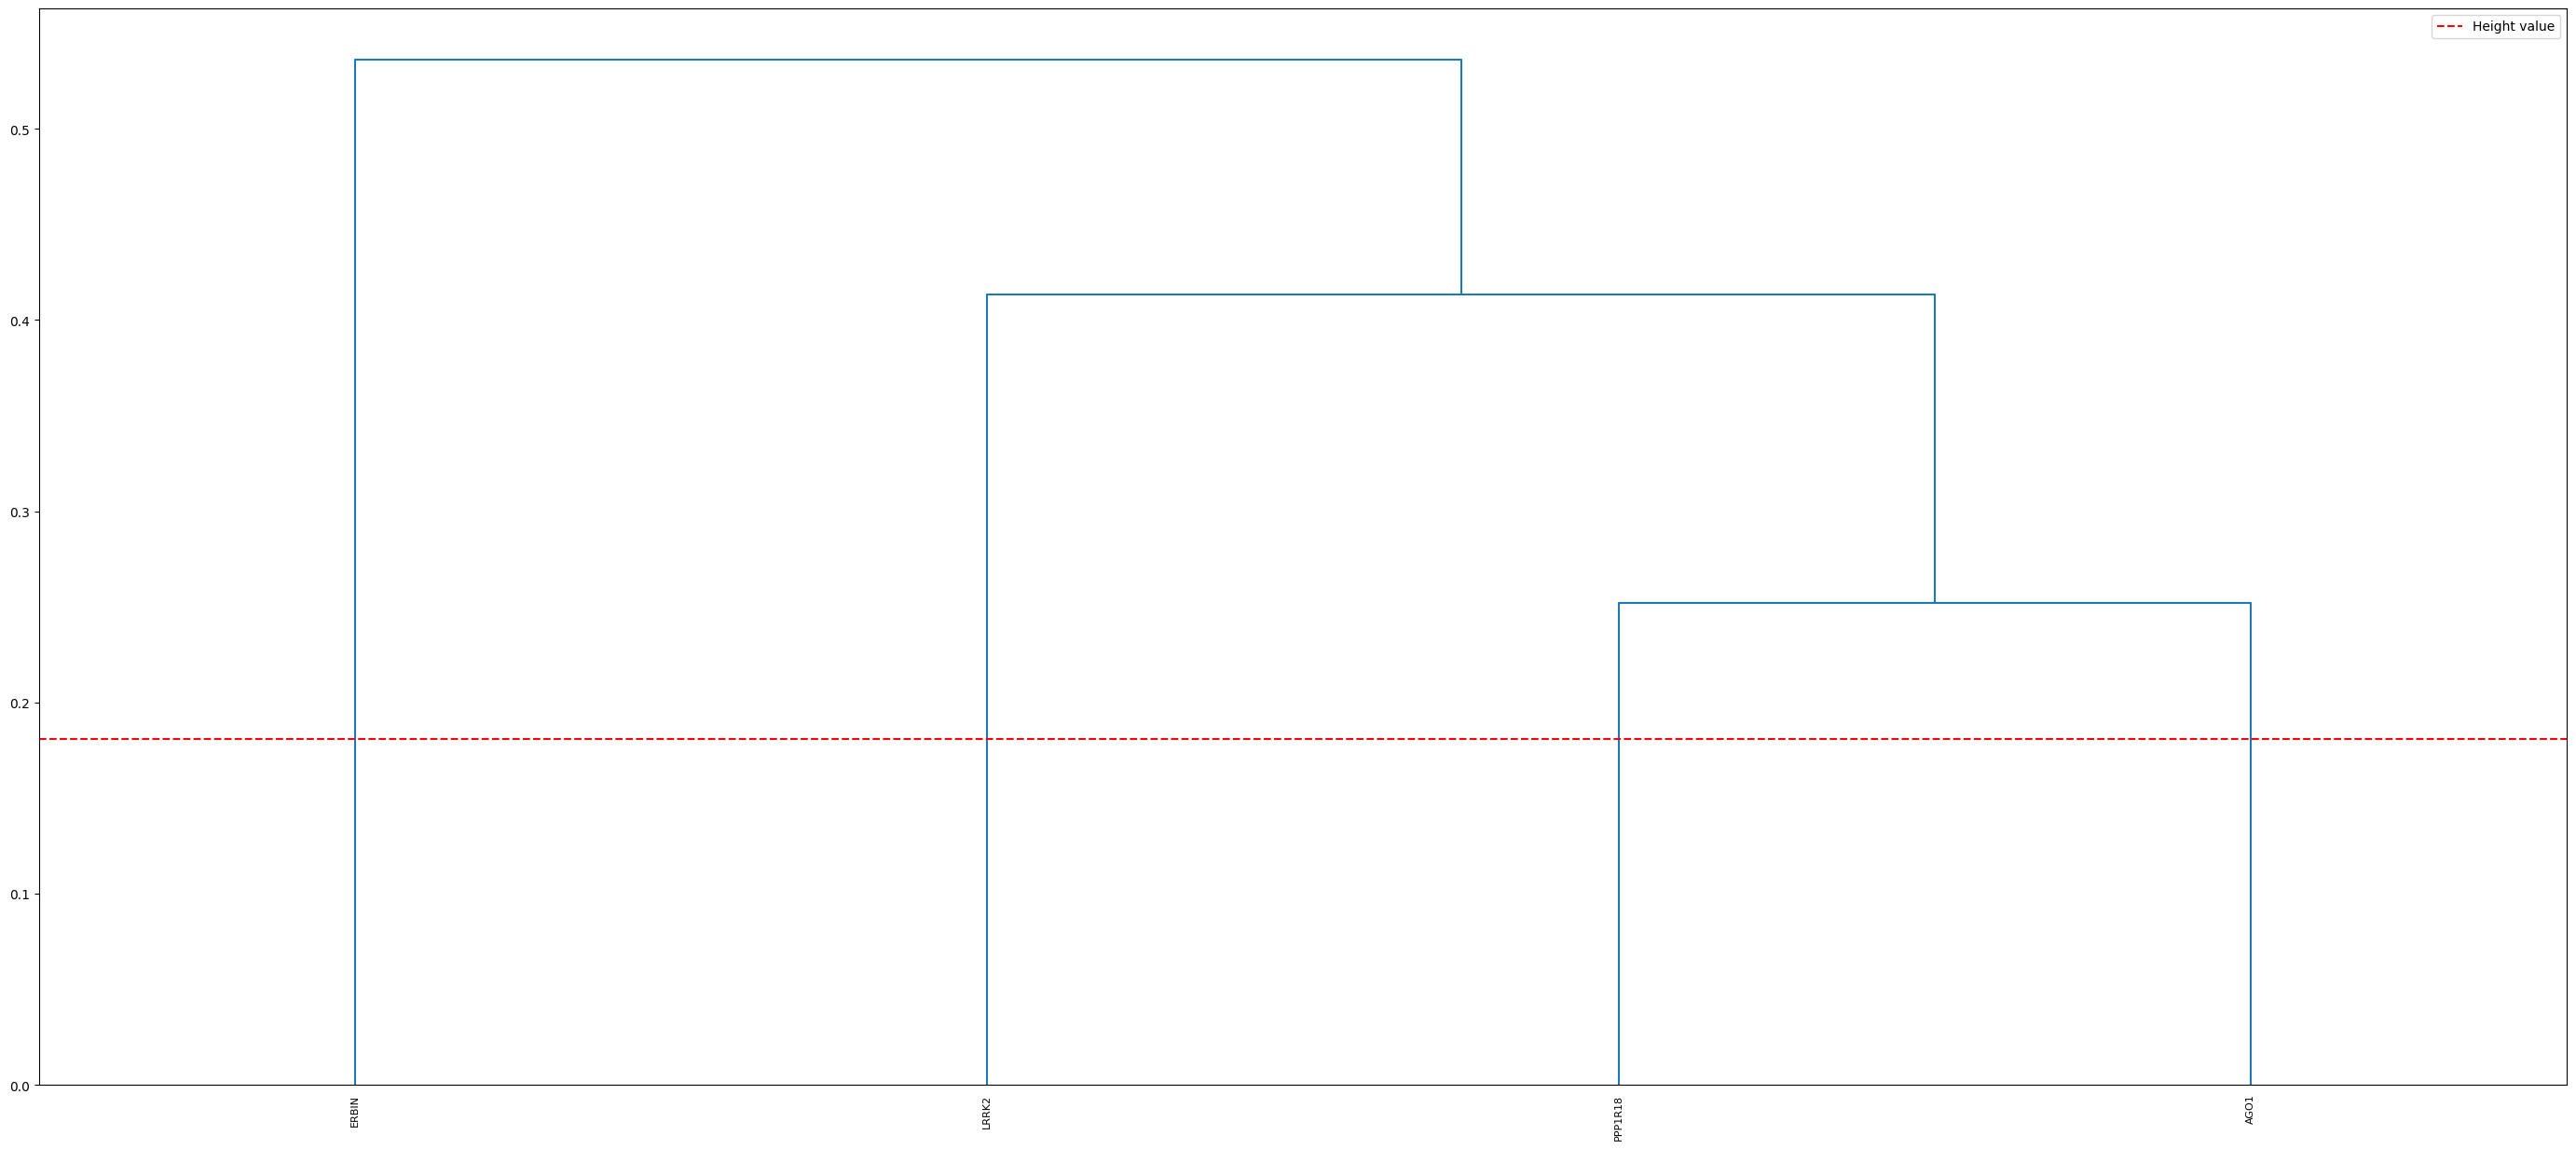

Iteration 1: 4 unassigned genes found.
Cluster numbers: 4
Found no significant clustering at iteration 2, finishing process.


In [11]:
endo.define_endotypes()

#### Old plotting

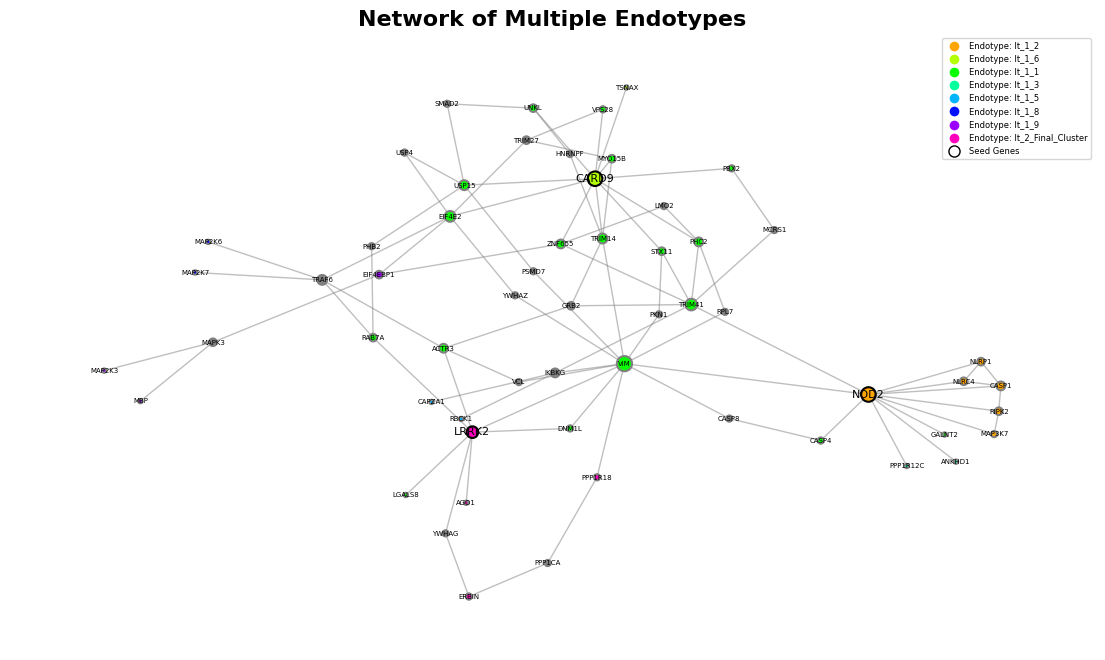

In [12]:
endo.plot_multiple_endotypes(node_size='degree', path_length=2)

### New Endotype clustering

In [19]:
endo.define_kl_endotypes(distance_metric='jaccard',linkage_method='complete',alpha=0.05)

--- Starting Analysis Pipeline ---

Step 1: Prepared dataset with 41 samples and 909 features.

Step 2: Created hierarchy with SciPy linkage.
Step 3: Converted hierarchy to PosetTree structure.
Step 4: Calculated KL-divergence for all nodes in the tree.
Step 5: Annotated tree with multiple statistical significance tests.
Step 6: Decomposed the tree to extract significant clusters.

--- Analysis Complete ---

Algorithm found 3 clusters.
  - Cluster 0 (root: N57): 11 samples
  - Cluster 1 (root: N64): 8 samples
  - Cluster 2 (root: N79): 22 samples


#### MDS of feature matrix

In [20]:
import numpy as np
import pandas as pd
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import pairwise_distances
import plotly.express as px
import plotly.graph_objects as go

feat_mat = endo.feature_matrix

# Get endotype labels for coloring
# endo.endotypes returns a tuple (dict_mapping, dict_clusters)
# Extract the mapping dictionary and get labels in the same order as the feature matrix
endotype_mapping = endo.endotypes[0]
endotype_labels = pd.Series([endotype_mapping[gene] for gene in feat_mat.index])

# Convert feature matrix to numpy array
X = np.array(feat_mat)

# Compute distance matrix (use same metric as clustering - 'jaccard' in this case)
distance_matrix = pairwise_distances(X, metric='jaccard')

# MDS parameters
n_components = 3  # Set to 2 for 2D plot, 3 for 3D plot
random_state = 42

# Plot dimensions (in pixels)
plot_width = 1000
plot_height = 600

# Perform MDS on the distance matrix (use dissimilarity='precomputed')
mds = MDS(n_components=n_components, random_state=random_state, dissimilarity='precomputed')
mds_result = mds.fit_transform(distance_matrix)

# Create DataFrame for plotting
if n_components == 2:
    mds_df = pd.DataFrame(
        data=mds_result,
        columns=['MDS1', 'MDS2']
    )
    mds_df['Endotype'] = endotype_labels.astype(str)
    mds_df['Gene'] = feat_mat.index
    
    # Plot 2D MDS
    fig_mds = px.scatter(
        mds_df,
        x='MDS1',
        y='MDS2',
        color='Endotype',
        hover_data=['Gene'],
        title='2D MDS of Distance Matrix (Jaccard)',
        width=plot_width,
        height=plot_height
    )
elif n_components == 3:
    mds_df = pd.DataFrame(
        data=mds_result,
        columns=['MDS1', 'MDS2', 'MDS3']
    )
    mds_df['Endotype'] = endotype_labels.astype(str)
    mds_df['Gene'] = feat_mat.index
    
    # Plot 3D MDS
    fig_mds = px.scatter_3d(
        mds_df,
        x='MDS1',
        y='MDS2',
        z='MDS3',
        color='Endotype',
        hover_data=['Gene'],
        title='3D MDS of Distance Matrix (Jaccard)',
        width=plot_width,
        height=plot_height
    )

fig_mds.show()


/home/itest/EndotypY_new/test_end_endotyping_package/lib/python3.12/site-packages/sklearn/metrics/pairwise.py:2463: DataConversionWarning:

Data was converted to boolean for metric jaccard

/home/itest/EndotypY_new/test_end_endotyping_package/lib/python3.12/site-packages/sklearn/manifold/_mds.py:677: FutureWarning:

The default value of `n_init` will change from 4 to 1 in 1.9.



In [21]:
from EndotypY import visualization

#### Plotting Endotypes of new clustering

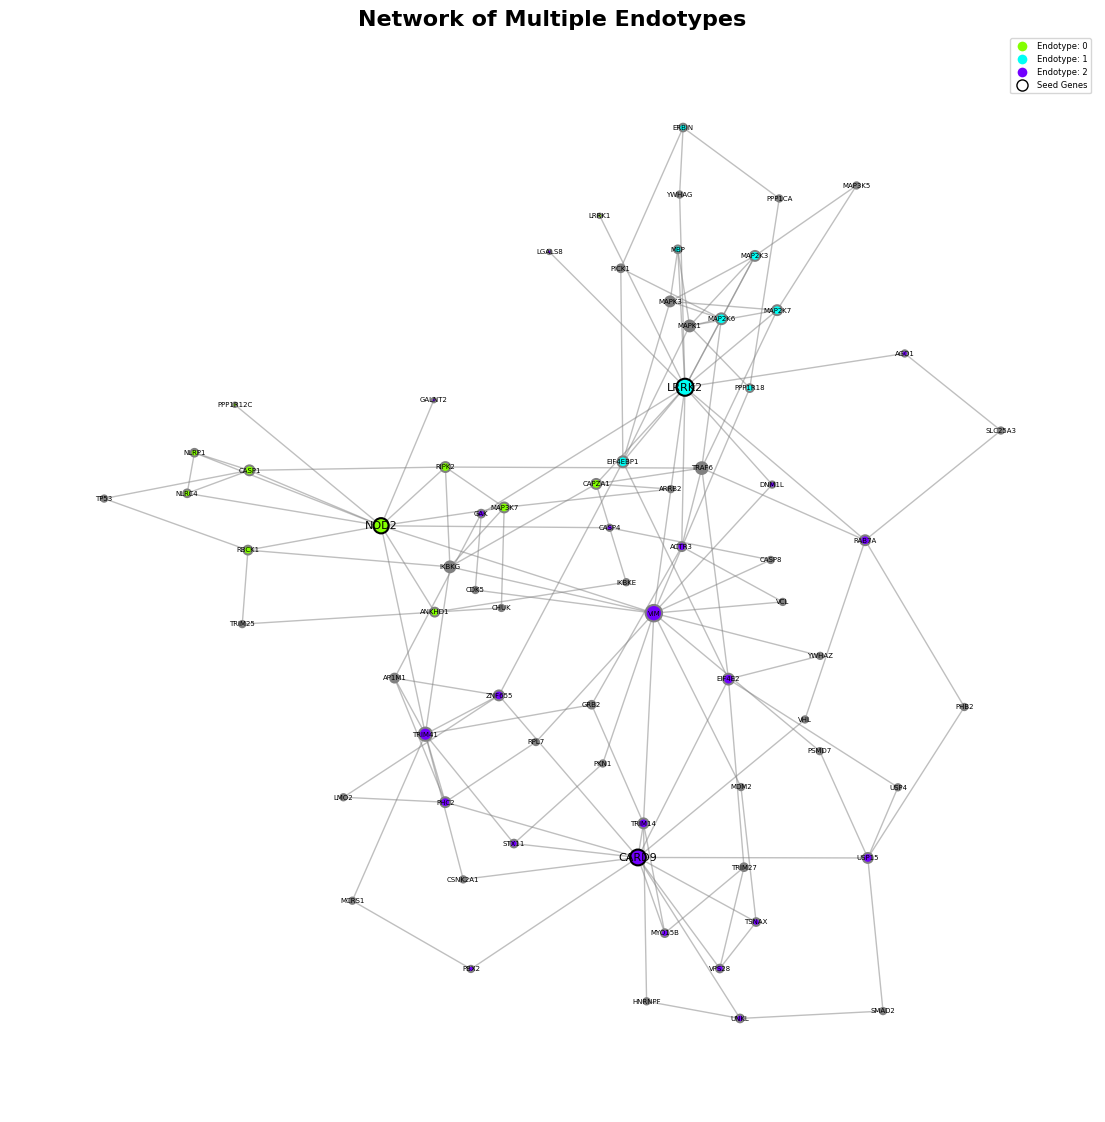

In [22]:
visualization.plot_multiple_endotypes(endo.endotypes[2],seed_genes=endo.seeds,G=endo.network,path_length=2,node_size='degree',layout_seed=42)

In [23]:
class_attributes = vars(endo).keys()

for attr in class_attributes:
    print(attr)

network
seeds
rwr_matrix
scaling_matrix
idx_ensembl
disease_module
connected_subgraph
seed_clustering_neighborhoods
seed_clusters
expanded_neighborhoods
neighborhood_annotation
feature_matrix
endotypes


In [24]:
# save endo.network to tsv edgelist file
import networkx as nx
nx.write_edgelist(endo.network, 'endotypes_IBD_network.tsv', delimiter='\t', data=False)

In [25]:
#save endo.endotypes[0] as tsv file
import pandas as pd
endotype_df = pd.DataFrame(list(endo.endotypes[0].items()), columns=['Gene', 'Endotype'])
endotype_df.to_csv('endotypes_IBD_Reactome_Pathways_2024.tsv', sep='\t', index=False)